Loaded data of size: (200, 200, 180)
Loaded data of size: (200, 200, 180)
Loaded data of size: (200, 200, 180)


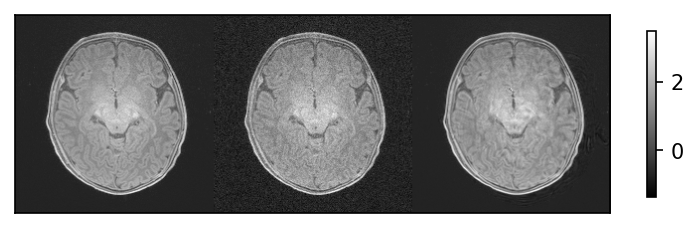

In [12]:
import numpy as np
from dipy.io.image import save_nifti, load_nifti
import torchio as tio
import torch
import torchio.transforms as transforms
import matplotlib.pyplot as plt

def show_img(img):
    img = np.squeeze(img)
    plt.figure(dpi=150)
    plt.imshow(img, cmap='gray')
    # plt.colorbar()
    cbar = plt.colorbar(shrink=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.show()

raw_data = np.load('2. RandomGhosting\BCP_G_clean.npy')
print('Loaded data of size:', raw_data.shape)

noisy_data = np.load('1. RandomNoise\BCP_G_noisy.npy')
print('Loaded data of size:', noisy_data.shape)

motion_data = np.load('2. RandomGhosting\BCP_G_motion.npy')
print('Loaded data of size:', motion_data.shape)

zz = 100
show_img(np.concatenate((raw_data[:,:,zz].squeeze(), noisy_data[:,:,zz].squeeze(), motion_data[:,:,zz].squeeze()),1))

In [42]:
tmp_expanded = np.expand_dims(motion_data, axis=0)
print(tmp_expanded.shape)

# numpy 배열을 ScalarImage로 변환
scalar_image = tio.ScalarImage(tensor=tmp_expanded)

# Subject 객체에 ScalarImage 추가
artifact_subject = tio.Subject(image=scalar_image)

noise_transform = tio.RandomNoise(mean=(0, 0), std=(0, 0.3))

transformed_subject = noise_transform(artifact_subject)

m_n_data = transformed_subject.image.data.numpy().squeeze()

print(m_n_data.shape)

a_n_max_value = np.max(m_n_data)
print("N_Max:", a_n_max_value)

a_n_min_value = np.min(m_n_data)
print("N_Min:", a_n_min_value)

a_n_mean_value = np.mean(m_n_data)
print("N_Mean:", a_n_mean_value)

a_n_std_value = np.std(m_n_data)
print("N_Std:", a_n_std_value)

(1, 200, 200, 180)
(200, 200, 180)
N_Max: 6.717759
N_Min: -1.8910238
N_Mean: 0.00012276639
N_Std: 1.0067877


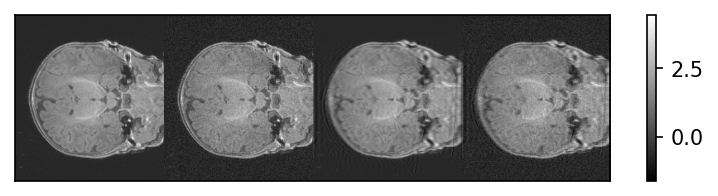

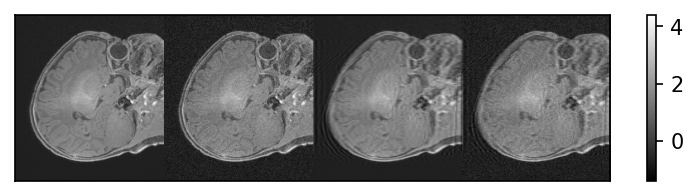

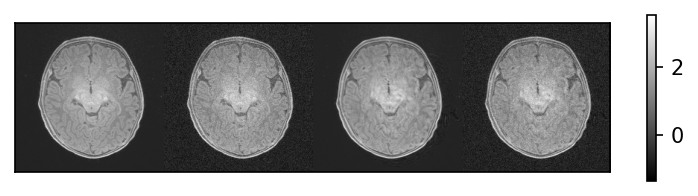

In [43]:
xx = 100
yy = 80
zz = 100
show_img(np.concatenate((raw_data[xx,:,:].squeeze(), noisy_data[xx,:,:].squeeze(), motion_data[xx,:,:].squeeze(), m_n_data[xx,:,:].squeeze()),1))
show_img(np.concatenate((raw_data[:,yy,:].squeeze(), noisy_data[:,yy,:].squeeze(), motion_data[:,yy,:].squeeze(), m_n_data[:,yy,:].squeeze()),1))
show_img(np.concatenate((raw_data[:,:,zz].squeeze(), noisy_data[:,:,zz].squeeze(), motion_data[:,:,zz].squeeze(), m_n_data[:,:,zz].squeeze()),1))

### Calculate SNR

In [44]:
def calculate_snr(image):
    signal_roi_size = (100, 100)
    signal_roi_position = (image.shape[0] // 2 - signal_roi_size[0] // 2, image.shape[1] // 2 - signal_roi_size[1] // 2)
    signal_roi = image[signal_roi_position[0]:signal_roi_position[0]+signal_roi_size[0], signal_roi_position[1]:signal_roi_position[1]+signal_roi_size[1]]

    noise_roi_size = (30, 30)
    noise_roi_positions = [
        (0, 0),
        (0, image.shape[1] - noise_roi_size[1]),
        (image.shape[0] - noise_roi_size[0], 0),
        (image.shape[0] - noise_roi_size[0], image.shape[1] - noise_roi_size[1])
    ]
    noise_rois = [image[pos[0]:pos[0]+noise_roi_size[0], pos[1]:pos[1]+noise_roi_size[1]] for pos in noise_roi_positions]

    signal_mean = np.mean(signal_roi)
    noise_std = np.std(noise_rois)

    if noise_std == 0:
        snr = float('inf')
    else:
        snr = signal_mean / noise_std

    return snr

In [45]:
zz = 100
print('SNR_Raw:', calculate_snr(raw_data[:,:,zz].squeeze()))
print('SNR_Noisy:', calculate_snr(noisy_data[:,:,zz].squeeze()))
print('SNR_Motion:', calculate_snr(motion_data[:,:,zz].squeeze()))
print('SNR_Motion_Noisy:', calculate_snr(m_n_data[:,:,zz].squeeze()))

SNR_Raw: 52.07623
SNR_Noisy: 9.185526
SNR_Motion: 64.177536
SNR_Motion_Noisy: 8.917196


### Calculate nRMSE

In [47]:
def nrmse(predicted, actual):
    mse = np.mean((predicted - actual) ** 2)  # 평균 제곱 오차 계산
    rmse = np.sqrt(mse)  # 평균 제곱근 오차 계산
    range_val = np.max(actual) - np.min(actual)  # 실제값의 범위 계산
    nrmse_val = rmse / range_val  # 정규화된 평균 제곱근 오차 계산
    return nrmse_val

In [48]:
yy = 80
print('nRMSE_noisy=', round(nrmse(noisy_data[:,yy,:].squeeze(), raw_data[:,yy,:].squeeze())*100, 2), '%')
print('nRMSE_motion=', round(nrmse(motion_data[:,yy,:].squeeze(), raw_data[:,yy,:].squeeze())*100, 2), '%')
print('nRMSE_motion_noisy=', round(nrmse(m_n_data[:,yy,:].squeeze(), raw_data[:,yy,:].squeeze())*100, 2), '%')

nRMSE_noisy= 3.53 %
nRMSE_motion= 4.51 %
nRMSE_motion_noisy= 5.75 %


In [15]:
np.save('BCP_G_M_N.npy', m_n_data.squeeze())